# Example of videomode tuning

In this example we show how to initialize and use the videomode for 1D and 2D scans of gates. Note that the code shown below is not suitable for running via this Jupyter notebook, because videomode requires actual hardware to work with, which is probably not available from the PC this example is being run on.

Author: Sjaak van Diepen, Pieter Eendebak

In [1]:
%gui qt
import matplotlib.pyplot as plt
import tempfile
import imageio
import qcodes
import qtt
from qtt.instrument_drivers.gates import VirtualDAC
from qtt.instrument_drivers.virtual_instruments import VirtualIVVI
from qcodes.station import Station
from qcodes_contrib_drivers.drivers.Spectrum.M4i import M4i
from qtt.measurements.videomode import VideoMode
from qtt.instrument_drivers.virtualAwg.virtual_awg import VirtualAwg
from qcodes_contrib_drivers.drivers.ZurichInstruments.ZIHDAWG8 import ZIHDAWG8

Windows found

#### Import modules and create a station with DAC modules and an AWG

Import the station and the VideoMode class. Here we use the stationV2 as an example, because there is not a virtual station available which can be used for a simulation of the videomode.

In [3]:
ivvi = VirtualIVVI(name='ivvi0', model=None)
gates = VirtualDAC('gates', [ivvi], {'P1': (0, 1), 'P2': (0, 2), 'P3': (0,3), 'P4': (0,4)})

station = Station(ivvi, gates)

m4i = qcodes.find_or_create_instrument(M4i, name='m4i')
m4i.timeout(15*1e3)  # set timeout of 10 seconds
m4i.sample_rate(1e6)
    
station.add_component(m4i)

'm4i'

In [4]:
address = 'DEV8049'
awg = qcodes.find_or_create_instrument(ZIHDAWG8, 'awg8', device_id=address)
station.add_component(awg)

Connected to: None awg8 (serial:None, firmware:None) in 12.44s


'awg8'

#### Initialize the virtual AWG

In [5]:
from qcodes.utils.validators import Numbers

class HardwareType(qcodes.Instrument):

    def __init__(self, name, awg_map, awg_scalings={}, **kwargs):
        super().__init__(name, **kwargs)

        self.awg_map = awg_map
        for gate in self.awg_map.keys():
            p = 'awg_to_%s' % gate
            self.add_parameter(p, parameter_class=qcodes.ManualParameter,
                               initial_value=awg_scalings.get(gate, 1),
                               label='{} (factor)'.format(p), unit='mV/V',
                               vals=Numbers(0, 400))

    def get_idn(self):
        ''' Overrule because the default VISA command does not work '''
        IDN = {'vendor': 'QuTech', 'model': 'hardwareV2',
               'serial': None, 'firmware': None}
        return IDN

awg_map = {'P1': (0, 5 - 1), 'P2': (0, 6 - 1), 'P3': (0, 7-1), 'm4i_mk': (0, 5 - 1, 0)}
awg_scalings = {f'P{ii}': 300. for ii in range(1,4)}

hardware = HardwareType(qtt.measurements.scans.instrumentName('hardware'), awg_map, awg_scalings)
station.add_component(hardware)

virtual_awg = VirtualAwg([awg], hardware, qtt.measurements.scans.instrumentName('virtual_awg'))
virtual_awg.digitizer_marker_delay(17e-6)
virtual_awg.digitizer_marker_uptime(50e-6)

station.add_component(virtual_awg)

'virtual_awg'

#### 1D - videomode

First set which parameter to sweep, this must be a parameter of the gates instrument in the station, over which range (in milliVolt) to sweep and which FPGA channel to acquire the data from. Then we would run the last line in the cell below, which starts a GUI that looks like the image below. This image is a print screen taken of a 1D videomode.

In [6]:
sweepparams = 'P1'
sweepranges = .8

vm = VideoMode(station, sweepparams=sweepparams, sweepranges=sweepranges, minstrument=(m4i, [0,1]), resolution=[32,64])

live_plotting: is1dscan True
live_plotting: is1dscan True
enable_averaging called, undefined: value True
enable_averaging called, undefined: value True
VideoMode: run 


VideoMode: run: startreadout
VideoMode: start readout


<img src="../../../qtt/exampledata/videomode_1d_printscreen.png">

We show the VideoMode window in the notebook by taking a screenshot.

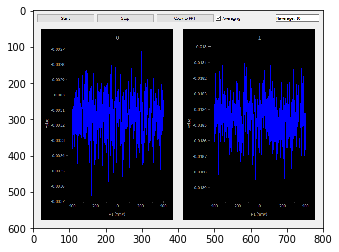

In [7]:
def make_screenshot(vm):
    fname=tempfile.mktemp(suffix='.png')
    vm.mainwin.grab().save(fname)
    im=imageio.read(fname)
    im=im.get_data(0)
    plt.figure()
    _=plt.imshow(im)
make_screenshot(vm)

We can also get the data acquired in DataSet format.

In [ ]:
dataset=vm.get_dataset()[0]
qtt.data.plot_dataset(dataset)
vm.stop()

##### About the GUI

The framerate of the videomode is shown in the title of the window. When this print screen was taken the framerate was 16.02 frames per second. The "Start" and "Stop" buttons can be used for starting and stopping the videomode. Note that these buttons control both the plotting and the AWG sweep. The recorded data is available via the method `get_dataset` the videomode object. In the Naverage field the user can adjust the averaging.

#### 2D - videomode

In [12]:
sweepparams = ['P2', 'P3']
sweepranges = [100, 100]
vm = VideoMode(station, sweepparams=sweepparams, sweepranges=sweepranges, minstrument=(m4i, [0,1]))

live_plotting: is1dscan False
live_plotting: is1dscan False
enable_averaging called, undefined: value True
enable_averaging called, undefined: value True
VideoMode: run 


VideoMode: run: startreadout
VideoMode: start readout


In [ ]:
make_screenshot(vm)

<img src="../../../qtt/exampledata/videomode_2d_printscreen.png">